# Self-Driving Car Engineer Nanodegree


## Project: **Vehicle Detection**

In this project, your goal is to write a software pipeline to identify vehicles in a video from a front-facing camera on a car. 

## Import Packages

In [158]:
import os, time, glob
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.grid_search import GridSearchCV
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

print('.')

.


## Input data

#### Load data

In [159]:
# read in our vehicles and non-vehicles
cars_gti = glob.glob('dataset/vehicles/GTI/**/*.png', recursive=True)
cars_kitti = glob.glob('dataset/vehicles/KITTI/**/*.png', recursive=True)
notcars = glob.glob('dataset/non-vehicles/**/*.png', recursive=True)

# sort and filter time-series data to remove nearly identical images
cars_gti = sorted(cars_gti)[::8]
cars = cars_gti + cars_kitti

# shuffle data
np.random.shuffle(cars)
np.random.shuffle(notcars)

# define a labels
y = np.hstack((np.ones(len(cars)), np.zeros(len(notcars))))

print(str(len(cars)) + ' cars')
print(str(len(notcars)) + ' notcars')

6320 cars
8968 notcars


#### Visualize data in different color spaces

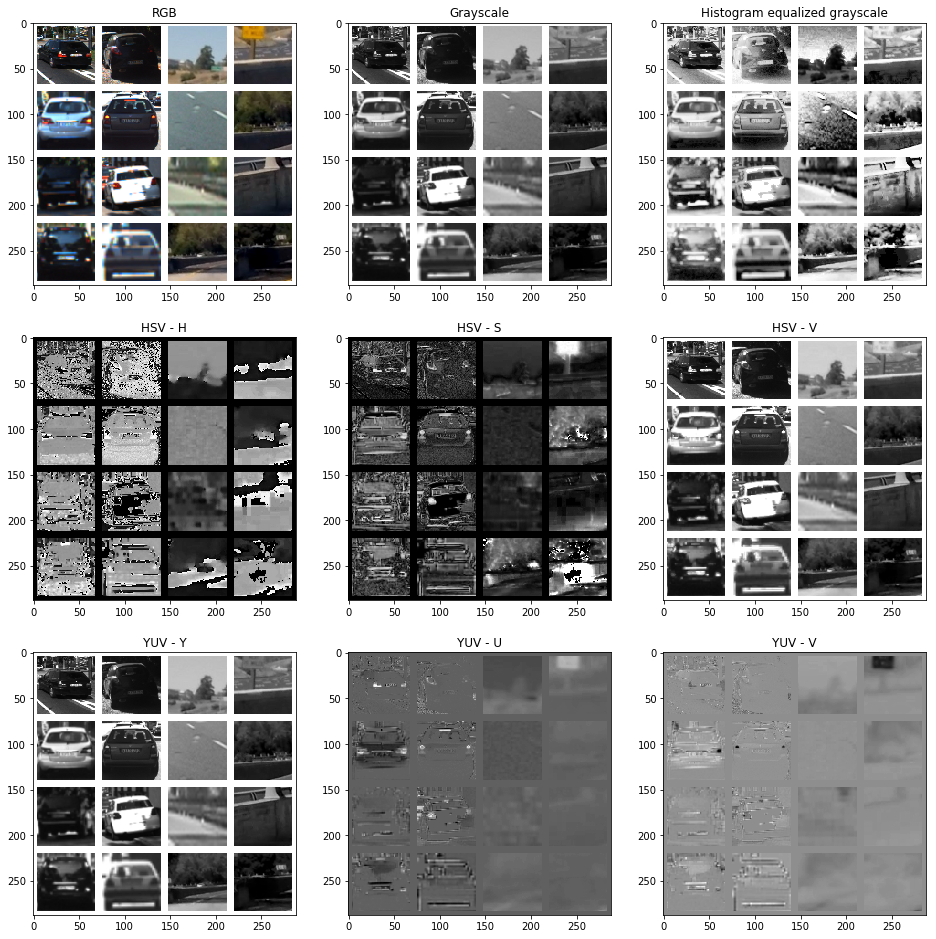

In [160]:
image = None
im_rgb = None
im_grayhist = None
for r in range(4):
    row_img = None
    row_img2 = None
    for c in range(2):
        img = cv2.imread(cars[np.random.randint(len(cars))])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img2 = cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
        img = np.lib.pad(img, (4,4), 'constant', constant_values=(255,255))[:,:,4:7]
        row_img = np.hstack((row_img,img)) if row_img is not None else img
        img2 = np.lib.pad(img2, (4,4), 'constant', constant_values=(255,255))
        row_img2 = np.hstack((row_img2,img2)) if row_img2 is not None else img2
    for nc in range(2):
        img = cv2.imread(notcars[np.random.randint(len(notcars))])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img2 = cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
        img = np.lib.pad(img, (4,4), 'constant', constant_values=(255,255))[:,:,4:7]
        row_img = np.hstack((row_img,img))
        img2 = np.lib.pad(img2, (4,4), 'constant', constant_values=(255,255))
        row_img2 = np.hstack((row_img2,img2)) if row_img2 is not None else img2
    im_rgb = np.vstack((im_rgb,row_img)) if im_rgb is not None else row_img
    im_grayhist = np.vstack((im_grayhist,row_img2)) if im_grayhist is not None else row_img2

im_gray = cv2.cvtColor(im_rgb, cv2.COLOR_RGB2GRAY)
im_hsv = cv2.cvtColor(im_rgb, cv2.COLOR_RGB2HSV)
im_yuv = cv2.cvtColor(im_rgb, cv2.COLOR_RGB2YUV)
                
fig = plt.figure(figsize=(16,28))
plt.subplot(5,3,1)
plt.imshow(im_rgb)
plt.title('RGB')
plt.subplot(5,3,2)
plt.imshow(im_gray, cmap='gray')
plt.title('Grayscale')
plt.subplot(5,3,3)
plt.imshow(im_grayhist, cmap='gray')
plt.title('Histogram equalized grayscale')

cspaces = ((im_hsv, 'HSV'), (im_yuv, 'YUV'))
for cs in range(len(cspaces)):
    for layer in range(3):
        plt.subplot(5,3,4+cs*3+layer)
        plt.imshow(cspaces[cs][0][:,:,layer], cmap='gray')
        plt.title(cspaces[cs][1] + ' - ' + cspaces[cs][1][layer])

## Features

#### Feature set: spatial binning, color histogram and histogram of oriented gradiens (HOG)

In [161]:
# define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # return the individual histograms, bin_centers and feature vector
    return hist_features

# define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # return the feature vector
    return features

# define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False, block_norm='L2-Hys')
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec, block_norm='L2-Hys')
        return features

# define a function to extract features based on a Parameters object
def extract_feature(image, params):
    features = []
    # apply color conversion if other than 'RGB'
    if params.color_space != 'RGB':
        if params.color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif params.color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif params.color_space == 'GRAY':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        elif params.color_space == 'GRAY_HISTEQ':
            feature_image = cv2.equalizeHist(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
    else: feature_image = np.copy(image)      

    if params.spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=params.spatial_size)
        features.append(spatial_features)
    if params.hist_feat == True:
        hist_features = color_hist(feature_image, nbins=params.hist_bins)
        features.append(hist_features)
    if params.hog_feat == True:
        if params.color_space == 'GRAY' or params.color_space == 'GRAY_HISTEQ':
            hog_features = get_hog_features(feature_image[:,:], params.orient, 
                        params.pix_per_cell, params.cell_per_block, vis=False, feature_vec=True)
        elif params.hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], params.orient, 
                        params.pix_per_cell, params.cell_per_block, vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,params.hog_channel], params.orient, 
                        params.pix_per_cell, params.cell_per_block, vis=False, feature_vec=True)
        # append the new feature vector to the features list
        features.append(hog_features)
    return np.concatenate(features)

# general feature extraction from multiple image names
def extract_features(imgs, params):
    # create a list to append feature vectors to
    features = []
    # iterate through the list of images
    for file in imgs:
        file_features = []
        # read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        feature = extract_feature(image, params)
        features.append(feature)
    # return list of feature vectors
    return features

print('.')

.


#### Feature visualization

spatial binning features (432,)
color histogram features (144,)
HOG features 5292 (orient 9, pix_per_cell 8, cell_per_block 2)


array([ 0.00617965,  0.00387599,  0.00376002, ...,  0.00921595,
        0.0093935 ,  0.02517758])

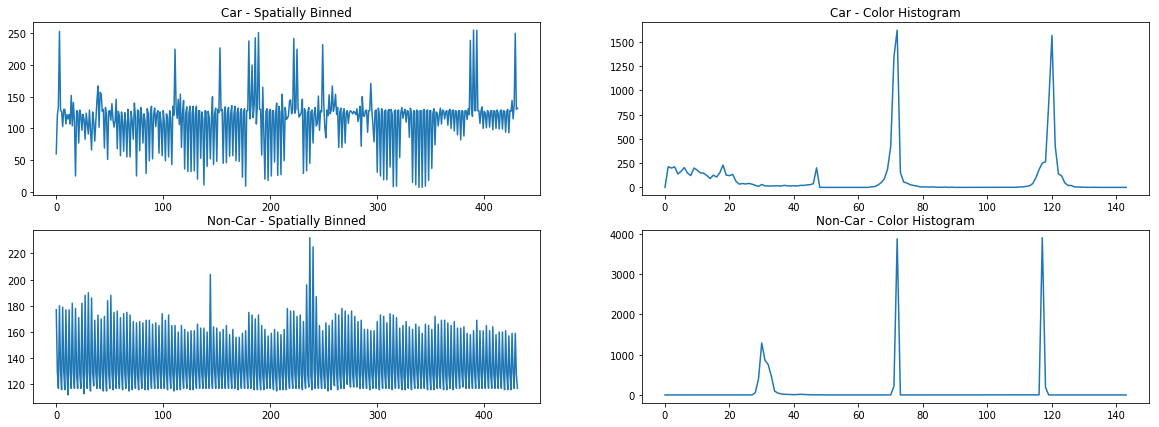

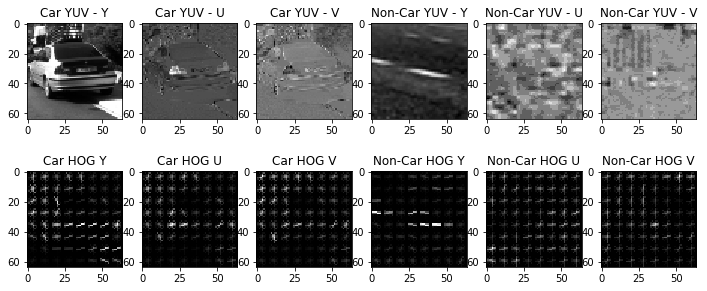

In [162]:
idx = np.random.randint(0, len(cars))
image = cv2.imread(cars[idx])
image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
image_nc = cv2.imread(notcars[idx])
image_nc = cv2.cvtColor(image_nc, cv2.COLOR_BGR2YUV)

# spatial binning of color
feature_bin_spatial = bin_spatial(image, size=(12, 12))
feature_bin_spatial_nc = bin_spatial(image_nc, size=(12, 12))
print('spatial binning features ' + str(feature_bin_spatial.shape))

# color histogram features
feature_color_hist = color_hist(image, nbins=48, bins_range=(0, 256))
feature_color_hist_nc = color_hist(image_nc, nbins=48, bins_range=(0, 256))
print('color histogram features ' + str(feature_color_hist.shape))

# plot results
fig = plt.figure(figsize=(20,7))
plt.subplot(221)
plt.plot(feature_bin_spatial)
plt.title('Car - Spatially Binned')
plt.subplot(222)
plt.plot(feature_color_hist)
plt.title('Car - Color Histogram')
plt.subplot(223)
plt.plot(feature_bin_spatial_nc)
plt.title('Non-Car - Spatially Binned')
plt.subplot(224)
plt.plot(feature_color_hist_nc)
plt.title('Non-Car - Color Histogram')

def visualize_hog(orient=9, pix_per_cell=8, cell_per_block=2, show_orig=False):
    # histogram of gradients features
    features_hog = []
    features_hog_nc = []
    images = []
    images_hog = []
    for channel in range(image.shape[2]):
        hog_feat, hog_image = get_hog_features(image[:,:,channel], orient,pix_per_cell, 
                                             cell_per_block, vis=True, feature_vec=True)
        features_hog.append(hog_feat)
        images.append(image[:,:,channel])
        images_hog.append(hog_image)
        hog_feat, hog_image = get_hog_features(image_nc[:,:,channel], orient,pix_per_cell, 
                                             cell_per_block, vis=True, feature_vec=True)
        features_hog_nc.append(hog_feat)
        images.append(image_nc[:,:,channel])
        images_hog.append(hog_image)
    features_hog = np.ravel(features_hog)
    features_hog_nc = np.ravel(features_hog_nc)
    print('HOG features ' + str(features_hog.ravel().shape[0]) + ' (orient ' + str(orient) + 
          ', pix_per_cell ' + str(pix_per_cell) + ', cell_per_block ' + str(cell_per_block) + ')')

    # plot hog example
    cs = 'YUV'
    r = 2 if show_orig else 1
    d = 7 if show_orig else 1
    fig = plt.figure(figsize=(12,5))
    for i in range(0,len(images),2):
        if show_orig:
            plt.subplot(r,6,i//2+1)
            plt.imshow(images[i], cmap='gray')
            plt.title('Car YUV - ' + cs[i//2])
        plt.subplot(r,6,i//2+d)
        plt.imshow(images_hog[i], cmap='gray')
        plt.title('Car HOG ' + cs[i//2])
        if show_orig:
            plt.subplot(r,6,i//2+4)
            plt.imshow(images[i+1], cmap='gray')
            plt.title('Non-Car YUV - ' + cs[i//2])
        plt.subplot(r,6,i//2+d+3)
        plt.imshow(images_hog[i+1], cmap='gray')
        plt.title('Non-Car HOG ' + cs[i//2])
    return features_hog

visualize_hog(orient=9, pix_per_cell=8, cell_per_block=2, show_orig=True)
#feature_hog = visualize_hog(orient=9, pix_per_cell=10, cell_per_block=2)

#### Testing feature descriptor strength with linear SVC

In [163]:
# split up data into randomized training and test sets once before testing features
X = cars + notcars
y = np.hstack((np.ones(len(cars)), np.zeros(len(notcars))))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 100))
print('Dataset size (training / test): ', len(X_train), '/', len(X_test))

Dataset size (training / test):  12230 / 3058


In [165]:
# save dataset to get consistent feature evaluation results
feat_testing_dataset = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test }
pickle.dump(feat_testing_dataset, open('feat_testing_dataset.p', 'wb'))

In [164]:
# reload dataset to get consistent feature evaluation results
feat_testing_dataset = pickle.load(open('feat_testing_dataset.p', 'rb'))
X_train = feat_testing_dataset['X_train']
X_test = feat_testing_dataset['X_test']
y_train= feat_testing_dataset['y_train']
y_test = feat_testing_dataset['y_test']
print('Dataset size (training / test): ', len(X_train), '/', len(X_test))

Dataset size (training / test):  12230 / 3058


In [166]:
# extracts features, scales them, then trains a linear SVC and returns its accuracy on test data
def train_svc(params, X_train, y_train, X_test, y_test, svm_C=1):
    # calc features, check its calculation time    
    t = time.time()
    X_train = extract_features(X_train, params)
    X_test = extract_features(X_test, params)
    print('Feature vector length:', len(X_train[0]))
    # scale features (per-column scaler)
    X_scaler = StandardScaler().fit(np.vstack((X_train, X_test)).astype(np.float64))
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)  
    t2 = time.time()
    print('Feature calculation time for test set (seconds):', round(t2-t, 5))
    # use a linear SVC 
    svc = LinearSVC(C=svm_C)
    # check the training time for the SVC
    t = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print('Training time:', round(t2-t, 2))
    # check accuracy on test data
    acc = round(svc.score(X_test, y_test), 4)
    print('Test Accuracy:', acc)
    # check the prediction time for test set
    t=time.time()
    svc.predict(X_test)
    t2 = time.time()
    print('Prediction time for test set (seconds):', round(t2-t, 5))
    return svc, X_scaler

# placeholder for parameters
class Parameters:
    def __init__(self):
        return  

params = Parameters()
params.color_space = 'YUV'       # Can be RGB, HSV, YUV, GRAY, GRAY_HISTEQ
params.spatial_size = (12, 12)   # Spatial binning dimensions
params.hist_bins = 48            # Number of histogram bins
params.orient = 9                # HOG orientations
params.pix_per_cell = 8         # HOG pixels per cell
params.cell_per_block = 8        # HOG cells per block
params.hog_channel = 'ALL'       # Can be 0, 1, 2, or 'ALL'
params.spatial_feat = True       # Spatial features on or off
params.hist_feat = True          # Histogram features on or off
params.hog_feat = True           # HOG features on or off  

In [26]:
(svc, X_scaler) = train_svc(params, X_train, y_train, X_test, y_test)

Feature vector length: 2304
Feature calculation time for test set (seconds): 38.80584
Training time: 4.1
Test Accuracy: 0.9928
Prediction time for test set (seconds): 0.00798


Results for only spatial binning

|Color Space |Spatial Size | Feature Vector Length | Test Accuracy|
|:--:|:--:|:-:|:--:| 
|RGB|(32, 32)|3072|0.939|
|RGB|(16, 16)|768|0.9444|
|RGB|(12, 12)|432|0.9441|
|RGB|(10, 10)|300|0.934|
|RGB|(8, 8)|192|0.929|
|HSV|(12, 12)|432|0.919|
|YUV|(12, 12)|432|0.947|*
|YUV|(16, 16)|768|0.942|
|GRAY|(20, 20)|400|0.893|
|GRAY_HISTEQ|(20, 20)|400|0.878|

Results for only color histograms

|Color Space |Histogram bins | Feature Vector Length | Test Accuracy|
|:--:|:--:|:-:|:--:| 
|RGB|48|144|0.961|
|RGB|32|96|0.959|
|RGB|24|72|0.956|
|RGB|16|48|0.939|
|RGB|12|36|0.917|
|HSV|24|72|0.968|
|YUV|24|72|0.969|
|YUV|32|96|0.971|
|YUV|40|120|0.971|
|YUV|48|144|0.972|*
|YUV|52|144|0.972|
|YUV|64|192|0.970|

Results for only HOG features

|Color Space | Channel | Orientations | Pixels per cell | Cells per block | Feature VLength | Test Accuracy|
| :--:| :-:| :--: | :--:| :-:| :--: | :--:|
|RGB|ALL|9|8|2|5292|0.946|
|HSV|ALL|9|8|2|5292|0.955|
|YUV|ALL|9|8|2|5292|0.973|
|GRAY|-|9|8|2|1764|0.938|
|GRAY_HISTEQ|-|9|8|2|1764|0.946|
|YUV|ALL|9|10|2|2700|0.973|
|YUV|0|9|10|2|900|0.943|
|YUV|1|9|10|2|900|0.958|
|YUV|2|9|10|2|900|0.948|
|YUV|UV|9|10|2|1800|0.966|
|YUV|ALL|9|8|1|1728|0.966|
|YUV|ALL|9|8|4|10800|0.966|
|YUV|ALL|9|8|6|8748|0.968|
|YUV|ALL|9|8|8|1728|0.978|*

Changing HOG pixels per cell from 8 to 10 decreases feature calculation times by 32%. Increasing it further produces much worse result, 10 seems acceptable, but the edges are missing in 64x64 images. Decreasing HOG orient to 8 does not look as good as 9. Combining spatial binning, color histrograms and HOG features I get accuracy around 0.99. 

#### Feature scaling visualization

[ -8.88178420e-17  -2.48689958e-16  -4.13002965e-16 ...,   1.36002321e-16
  -6.74460487e-17   8.32667268e-17]
[ 1.  1.  1. ...,  1.  1.  1.]


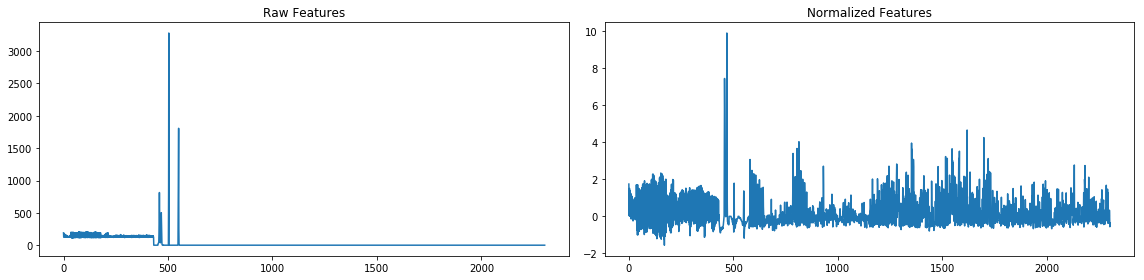

In [167]:
params.spatial_feat = True       # Spatial features on or off
params.hist_feat = True          # Histogram features on or off
params.hog_feat = True           # HOG features on or off

# calculate features on reduced dataset
Xtrain = extract_features(X_train[0:100], params)
Xtest = extract_features(X_test[0:100], params)
# fit a per-column scaler
X_scaler = StandardScaler().fit(np.vstack((Xtrain, Xtest)).astype(np.float64))
# apply the scaler to X_train
Xtrain_scaled = X_scaler.transform(Xtrain)
Xtest_scaled = X_scaler.transform(Xtest)
Xscaled = np.vstack((Xtrain_scaled, Xtest_scaled)).astype(np.float64)

# plot an example of raw and scaled features
idx = np.random.randint(0, 100)
fig = plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(Xtrain[idx])
plt.title('Raw Features')
plt.subplot(122)
plt.plot(Xtrain_scaled[idx])
plt.title('Normalized Features')
fig.tight_layout()

# scaled data should have zero mean and unit variance
print(Xscaled.mean(axis=0))
print(Xscaled.std(axis=0))

## Helper Functions

In [168]:
# draw custom rectangles on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6, random_color=False):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for bbox in bboxes:
        if random_color:
            color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img

# generate custom windows centered horizontally
def generate_windows(img, y_start=0.5, rows=1, cols=3, xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    (h, w) = img.shape[0:2]
    window_list = []
    col_cnt = 0
    # step for drawing next window with proper overlap
    stepx = np.int(xy_window[0] * (1-xy_overlap[0]))
    stepy = np.int(xy_window[1] * (1-xy_overlap[1]))
    # y coordinates of topmost centered window
    topy = h * y_start
    boty = h * y_start + xy_window[1]
    for r in range(rows):
        # y coordinates of centered window in a row
        topy = np.int(h * y_start + r * stepy)
        boty = topy + xy_window[1]
        # x coordinates of centered window in a row
        leftx = (w - xy_window[0])//2
        rightx = (w + xy_window[0])//2
        col_cnt = 0
        if boty < h and leftx > 0 and rightx < w and col_cnt < cols:
            # center window is the first in each line
            window_list.append(((leftx, topy), (rightx, boty)))
            col_cnt += 1
            leftx -= stepx
            rightx += stepx
            # then left and right windows follow as many as specified
            # using stepx for coordinate update
            while leftx > 0 and rightx < w and col_cnt < cols:
                window_list.append(((leftx, topy), (leftx+xy_window[0], boty)))
                window_list.append(((rightx-xy_window[0], topy), (rightx, boty)))
                leftx -= stepx
                rightx += stepx
                col_cnt += 2
    # return the list of windows
    print('n_windows ' + str(len(window_list)))
    return window_list

# define a single function that can extract features based on windows and make predictions
def search_windows(img, windows, clf, scaler, params):
    # create an empty list to receive positive detection windows
    on_windows = []
    # iterate over all windows in the list
    for window in windows:
        # extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        # extract features for that window using single_img_features()
        features = extract_feature(test_img, params)
        # scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # predict using your classifier
        prediction = clf.predict(test_features)
        # if positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # return windows for positive detections
    return on_windows

# define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, svc, X_scaler, params, ystart, ystop, ylast=None, xfirst=None, xlast=None, scale=1, xystep=(8,8)):
    detection_windows = []
    predictions = []
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    # apply color conversion if other than 'RGB'
    if params.color_space != 'RGB':
        if params.color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif params.color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif params.color_space == 'GRAY':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2GRAY)
        elif params.color_space == 'GRAY_HISTEQ':
            ctrans_tosearch = cv2.equalizeHist(cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2GRAY))
    else: ctrans_tosearch = np.copy(img_tosearch)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # define blocks and steps as above
    nxblocks = (ch1.shape[1] // params.pix_per_cell) - params.cell_per_block + 1
    nyblocks = (ch1.shape[0] // params.pix_per_cell) - params.cell_per_block + 1 
    nfeat_per_block = params.orient*params.cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // params.pix_per_cell) - params.cell_per_block + 1
    cells_per_step = xystep  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step[0] + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step[1] + 1
    
    # compute individual channel HOG features for the entire image
    if params.hog_feat:
        hog1 = get_hog_features(ch1, params.orient, params.pix_per_cell, params.cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, params.orient, params.pix_per_cell, params.cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, params.orient, params.pix_per_cell, params.cell_per_block, feature_vec=False)

    xfrom = xfirst if xfirst is not None else 0
    xto = xlast if xlast is not None else nxsteps
    yto = ylast if ylast is not None else nysteps
    for xb in range(xfrom, xto):
        for yb in range(0, yto):
            ypos = yb*cells_per_step[1]
            xpos = xb*cells_per_step[0]
            # extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*params.pix_per_cell
            ytop = ypos*params.pix_per_cell

            # extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # get color features
            spatial_features = bin_spatial(subimg, size=params.spatial_size)
            hist_features = color_hist(subimg, nbins=params.hist_bins)

            # scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            predictions.append(test_prediction)
            # get window coordinates on original image
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            detection_windows.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))

    return predictions, detection_windows

# filter class for car detections
class Detector():
    def __init__(self, img_shape=(720,1280), nframe=10, pa=6, pb=4.0, pc=4.0, in_video=True):
        self.w = img_shape[1]
        self.h = img_shape[0]
        self.prev_heatmap = np.zeros((self.h, self.w), dtype=np.float)
        self.in_video = in_video
        self.recent_windows = []
        self.nframe = nframe
        self.pa = pa  # parameter for static threshold
        self.pb = pb  # parameter for dynamic threshold depending on number of accumulated hot windows
        self.pc = pc  # multiply parameter for recent heatmap reuse
  
    def update(self, bbox_list):
        # storing bbox list
        self.recent_windows.append(bbox_list)
        if len(self.recent_windows) > self.nframe:
            # only preserve certain number of frames
            self.recent_windows.pop(0)
        # empty heatmap
        heatmap = np.zeros((self.h, self.w), dtype=np.float)
        # for counting all accumulated hot windows
        rects = 0
        for box_list in self.recent_windows:
            for box in box_list:
                # add heat for car predictions
                heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
                rects += 1
        if self.in_video:
            # reuse previous heatmap
            heatmap = np.add(heatmap, self.pc*self.prev_heatmap)
            # threshold static or dynamic limit
            heatmap[heatmap <= max(self.pa, np.int(rects/self.pb))] = 0    
        else:
            # empty state for test images
            heatmap[heatmap <= 1] = 0 
        self.prev_heatmap = heatmap
        # for debug purpose
        res = (heatmap/np.max(heatmap)*255).astype(np.uint8)
        return res

# define function drawing bounding boxes for labels
def draw_labeled_bboxes(img, labels):
    # iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # return the image
    return img
    
print('.')

.


## Window positions

#### Standard way

n_windows 38
n_windows 54
n_windows 46
n_windows 7


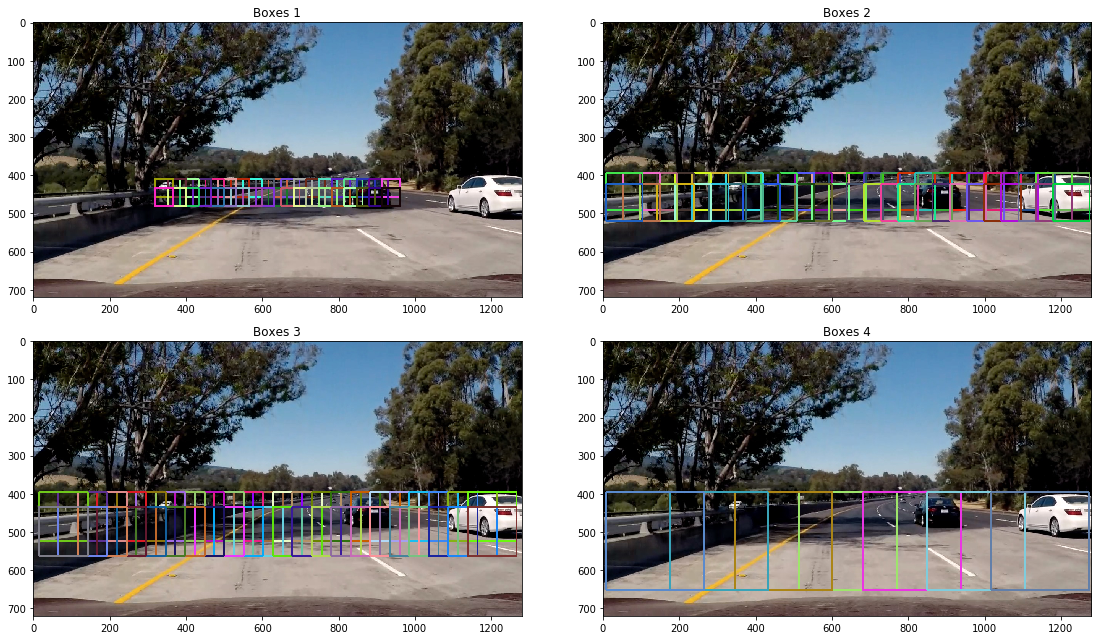

In [169]:
(h,w) = (720, 1280)
y_start = int(h * 0.55)

fn = 'test_images/test5.jpg'
img = cv2.imread(fn)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

windows_s = generate_windows(img, y_start=0.57, rows=2, cols=19, xy_window=(48, 48), xy_overlap=(0.3, 0.5))
windows_m = generate_windows(img, y_start=0.55, rows=2, cols=27, xy_window=(96, 96), xy_overlap=(0.53, 0.7))
windows_l = generate_windows(img, y_start=0.55, rows=2, cols=23, xy_window=(128, 128), xy_overlap=(0.6, 0.7))
windows_xl = generate_windows(img, y_start=0.55, rows=2, cols=7, xy_window=(256, 256), xy_overlap=(0.34, 0.73))

windowsM = windows_s + windows_m + windows_l + windows_xl
windows_final = windowsM

img_s = draw_boxes(img, windows_s, thick=4, random_color=True)
img_m = draw_boxes(img, windows_m, thick=4, random_color=True)
img_l = draw_boxes(img, windows_l, thick=4, random_color=True)
img_xl = draw_boxes(img, windows_xl, thick=4, random_color=True)
imgM = draw_boxes(img, windowsM, thick=4, random_color=True)

fig = plt.figure(figsize=(16,9))
for i, image in enumerate([img_s, img_m, img_l, img_xl]):
    plt.subplot(2,2,i+1)
    plt.imshow(image)
    plt.title('Boxes ' + str(i+1))
fig.tight_layout()

#### HOG subsampling

145


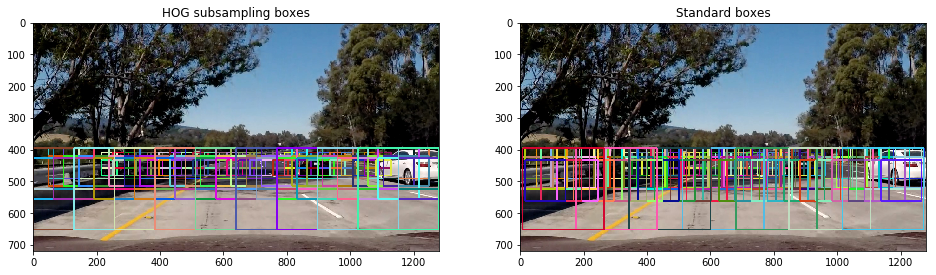

In [170]:
(preds, windows1) = find_cars(img, svc, X_scaler, params, 410, 510, ylast=2, xfirst=6, xlast=31, scale=0.75, xystep=(6,4))
(preds, windows2) = find_cars(img, svc, X_scaler, params, 396, 520, ylast=2, xfirst=1, xlast=None, scale=1.5, xystep=(4,2))
(preds, windows3) = find_cars(img, svc, X_scaler, params, 396, 580, ylast=2, xfirst=0, xlast=None, scale=2.0, xystep=(4,2))
(preds, windows4) = find_cars(img, svc, X_scaler, params, 396, 660, ylast=1, xfirst=0, xlast=None, scale=4.0, xystep=(4,2))
windows = windows1 + windows2 + windows3 + windows4
out_img = draw_boxes(img, windows, thick=3, random_color=True)
print(len(windows))
fig = plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(out_img)
plt.title('HOG subsampling boxes')
plt.subplot(1,2,2)
plt.imshow(imgM)
plt.title('Standard boxes')

Standard feature extraction and HOG subsampling was tested on video as well. Standard way gives 2.8 it/s, while HOG subsampling gives 2.2 it/s for this window setup. Quite surprising. So I will use the standard way.

## SVC Classifier

In [171]:
params = Parameters()
params.color_space = 'YUV'       # Can be RGB, HSV, YUV, GRAY, GRAY_HISTEQ
params.spatial_size = (12, 12)   # Spatial binning dimensions
params.hist_bins = 48            # Number of histogram bins
params.orient = 9                # HOG orientations
params.pix_per_cell = 8         # HOG pixels per cell
params.cell_per_block = 8        # HOG cells per block
params.hog_channel = 'ALL'       # Can be 0, 1, 2, or 'ALL'
params.spatial_feat = True       # Spatial features on or off
params.hist_feat = True          # Histogram features on or off
params.hog_feat = True           # HOG features on or off
print('Dataset size (training / test): ', len(X_train), '/', len(X_test))

Dataset size (training / test):  12230 / 3058


In [75]:
(svc, X_scaler) = train_svc(params, X_train, y_train, X_test, y_test, svm_C=0.01)

Feature vector length: 2304
Feature calculation time for test set (seconds): 38.91608
Training time: 1.48
Test Accuracy: 0.9925
Prediction time for test set (seconds): 0.00781


In [ ]:
# parameters = {'C':[0.0001, 0.005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]}
# svc = LinearSVC()
# clf = GridSearchCV(svc, parameters)
# clf.fit(X_train, y_train)

# grid_search_data = { 'svm': svc, 'clf': clf }
# pickle.dump(grid_search_data, open('grid_search_data.p', 'wb'))

# grid_search_pickle = pickle.load(open('grid_search_data.p', 'rb'))
# svc = grid_search_pickle['svm']
# clf = grid_search_pickle['clf']
# print(clf.grid_scores_)

## Analyze an image

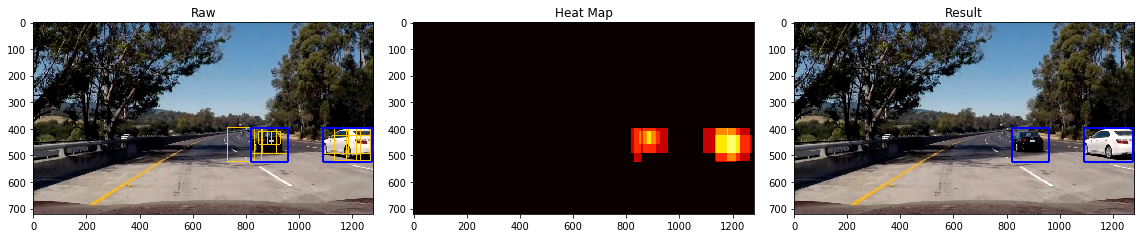

In [172]:
# save classifier data
# print(params.__dict__)
# classifier_data = { 'params': params, 'svc': svc, 'X_scaler': X_scaler }
# pickle.dump(classifier_data, open('classifier_data.p', 'wb'))

# reload classifier data
classifier_data = pickle.load(open('classifier_data.p', 'rb'))
params = classifier_data['params']
svc = classifier_data['svc']
X_scaler = classifier_data['X_scaler']

# analyze test image
hot_windows = search_windows(img, windows_final, svc, X_scaler, params)                       
window_img = draw_boxes(img, hot_windows, color=(250, 200, 0), thick=2)

detector = Detector(in_video=False)
heatmap = detector.update(hot_windows)
# Visualize the heatmap when displaying    
heatmap = np.clip(heatmap, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)
window_img = draw_labeled_bboxes(np.copy(window_img), labels)

fig = plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(window_img)
plt.title('Raw')
plt.subplot(132)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(133)
plt.imshow(draw_img)
plt.title('Result')
fig.tight_layout()

# Test on Videos

Let's see!

In [174]:
def process_image(image):
    # exract feature and make predictions on windows
    hot_windows = search_windows(image, windows_final, svc, X_scaler, params)  
    # draw all hot windows for debug purposes
    window_img = draw_boxes(image, hot_windows, color=(250, 200, 0), thick=2)
    # filter hot windows
    heatmap = detector.update(hot_windows)
    # visualize the heatmap when displaying    
    heatmap = np.clip(heatmap, 0, 255)
    # find final boxes from heatmap using label function
    labels = label(heatmap)
    window_img = draw_labeled_bboxes(np.copy(image), labels)
    return window_img

Let's try with the short test video first ...

In [147]:
detector = Detector(nframe=20, pa=12, pb=3.75, pc=0.3)
test_output = 'test_video_output.mp4'
#clip1 = VideoFileClip("test_video.mp4").subclip(0,0.25)
clip1 = VideoFileClip("test_video.mp4")
test_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4



 97%|█████████▋| 38/39 [00:13<00:00,  2.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 13.2 s, sys: 77.5 ms, total: 13.3 s
Wall time: 14.3 s


In [157]:
detector = Detector(nframe=20, pa=12, pb=3.75, pc=0.3)
project_video_output = 'project_video_output1.mp4'
#clip2 = VideoFileClip('project_video.mp4').subclip(4,6)
clip2 = VideoFileClip('project_video.mp4').subclip(8,10)
#clip2 = VideoFileClip('project_video.mp4').subclip(17,23)
#clip2 = VideoFileClip('project_video.mp4').subclip(23,32)
#clip2 = VideoFileClip('project_video.mp4')
project_clip = clip2.fl_image(process_image)
%time project_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output1.mp4
[MoviePy] Writing video project_video_output1.mp4



 98%|█████████▊| 50/51 [00:17<00:00,  2.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output1.mp4 

CPU times: user 17.4 s, sys: 109 ms, total: 17.6 s
Wall time: 18.5 s


## Writeup

Here is a [link](./writeup.md) to my writeup of this project.